In [ ]:
import numpy as np
import copy
import matplotlib.pylab as plt
import pickle # helps save and load some complicated objects (aka data structures)
from sklearn.pipeline import Pipeline # These both help with rescaling your data (which must be done every time)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf # Some folks use pytorch instead
from tensorflow.keras.models import Model
np.random.seed(12211)  

In [1]:
num_train = 200000 # Training comes from synthetic dataset
num_test = 20000   # Testing is applied to actual observations
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]
surveystring = ['Primus', 'Vipers', 'SDSS', 'DEEP2', 'Wiggle-z'] # 5 types of observations

n_epochs = 2000 #20 # How long the training goes on (1 epoch = entire neural network goes through entire training data once)
D = 5 # Dimensions of inputs
K = 3 # Number of "components"
      # aka dimensions of outputs divided by 3 (there are actually 9 output parameters per galaxy)
learning_rate = 1e-5 # determines how fast the weights or the coefficients of the network are updated. # Is this like step size?
decay_rate= 1e-3 # like "friction" -- so that weights don't just increase/decrease monotonically (right ?)
batch_size = 1024 # number of training examples passed through the network at once
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [2]:
def load_trained_models(save_mod): # save_mod includes the three files that we specified as part of our architecture, above
    # Training has already taken place, this is loading in all the weights (at the nodes in hidden layers) that you found via training
    # Prepare to match the incoming data to the rescaling that we did during training
    
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())]) # Preproc = preprocessing, these are the "transforms" later
        # Pipeline of transforms with a final estimator. Sequentially apply a list of transforms and a final estimator.
    scalerfile = save_mod + '_scaling_X' # This is just a way to organize the names
    preproc = pickle.load(open(scalerfile, 'rb')) # Okay, not sure what's going on around this area (throwing an error rn)
    
    ## load rescaling routine for redshift                # What exactly is a rescaling routine?
        # Rescaling is when you change your parameters to fall within a specific range
        # For instance, in standard rescaling, x' = (x - mu)/sigma where mu = mean(X) and sigma = stddev(X)
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())]) # These are the "transforms" later
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb')) # Does y = redshift?
        # x' = (x - x_min)/(x_max - x_min)

    ## Mixed density network            # See figure 2
        # combines a conventional neural network with a mixture density model to predict the conditional probability in Equation 1
        # Where is loss function in this? We are using a generic negative log likelihood function instead of an MSE loss function
    non_lin_act = tf.nn.relu #tf.nn.tanh
        # ReLU is a type of non-linear activation function
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs) 
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1) # Notice how "inputs" are always the previous line
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a) # Number of nodes gets wide, then narrow again
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5) # Last layer has only 32 nodes, no activation function
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)                                     # This is 3 outputs
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6)) # This is 3 outputs
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)                        # This is 3 outputs
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    # Output is actually P(z|c), but we can't compare to that so we output a single z (I guess?)
    return preproc, preproc_y, model_train # Returns rescaling for inputs, rescaling for outputsd, the actual neural network itself

In [3]:
def minmax_cutsOBSarr(X, y, l): # Training set has some limits -- make sure we stay within those
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    return X_new, y_new, l_new, mask_cond

In [4]:
def print_limits(X, y): # Just write the mins and maxs, range of redshift, etc.
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0)) # If color/magnitude min is probably of a star, cut it off
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [5]:
def loadTrainTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_may_2020/'): # Loading color and redshift info
    # Actually about implementing the testing!
    
    test_data = np.load(dirIn + 'test_' + Testset +'.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test) # prints number of datasets being tested, the redshift mins and maxes, and the color/magnitude mins/maxes

    if Testset == 'OBS':
        test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return _, _, X_test, y_test, test_labels # Why are there two blanks?

In [6]:
# Perturb individual inputs (10% is a lot, btw)
def perturb(X_test, band_n, delta_c = 1.1, approach_a = True):
    
    prtb_X_test = copy.deepcopy(X_test)

    if approach_a:
        prtb_X_test[:,band_n] = prtb_X_test[:,band_n]*delta_c # Increases everything by 10%
    else:
        np.random.seed(10) # Try multiple seeds
        #print(np.random.shuffle(prtb_X_test[:, band_n]))
        np.random.shuffle(prtb_X_test[:, band_n])

    # Quantify the results (i.e. mean squared error) -- Nesar will send some things
    return prtb_X_test

In [7]:
def predict(X_test):
    X_test = preproc.transform(X_test)
    y_pred = np.array(model_train(X_test))
    model_train(X_test[10:15])
    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
    y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
    return y_pred_mean, y_pred_std

In [8]:
def plot_side_by_sides(y_test, preproc_y, y_pred_means, y_pred_stds, labels): # Assume the last two inputs are lists of equal length
    
    #plt.figure(figsize=(10, 10))
    fig, axs = plt.subplots(1,len(y_pred_means), figsize=(10,7.5))
    for i, ax in enumerate(axs):
        ax.errorbar(y_test, preproc_y.inverse_transform(y_pred_means[i].reshape(-1, 1))[:, 0], # Inverse transform KNOWS what you did to get preproc_y :P
                 yerr= preproc_y.inverse_transform(y_pred_stds[i].reshape(-1, 1) )[:, 0], 
                 fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = labels[i])
        C = 0.05
        z_t = np.array([0, 1])
        z_tp = z_t + C*(1+z_t) # photo z's (predictions)
        z_tm = z_t - C*(1+z_t) # spectroscopic z's (trues)

        ax.plot(z_t, z_t, 'k')
        ax.plot(z_t, z_tp, 'k-.')
        ax.plot(z_t, z_tm, 'k-.')
        ax.set_ylabel(r'$z_{phot}$', fontsize=25)
        ax.set_xlabel(r'$z_{spec}$', fontsize=25)
        #plt.axes().set_aspect('equal')
        leg = ax.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)
    plt.tight_layout()
    return fig, axs

## Perturb Inputs

In [9]:
## Loading color, redshift information from different surveys
_, _, X_test, y_test, label_test = loadTrainTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_may_2020/') # Labels of actual data (see "surveystring")

NameError: name 'np' is not defined

In [ ]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.0 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test) # This is where we throw out stars and outliers
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

In [ ]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod)

In [10]:
# Perturb one band
band_n = 2
delta_c = 1.2
approach_a = True
prtb_X_test = perturb(X_test, band_n, delta_c = delta_c, approach_a = approach_a)

# Compare perturbed and unperturbed predictions (mean and std-dev)
og_y_pred_mean, og_y_pred_std = predict(X_test)
prtb_y_pred_mean, prtb_y_pred_std = predict(prtb_X_test)

# Plot those comparisons
labels = ["original", "perturbed: " + str(band_n)]
fig, axs = plot_side_by_sides(y_test, preproc_y, [og_y_pred_mean, prtb_y_pred_mean], [og_y_pred_std, prtb_y_pred_std], labels)

# Title and save
fig.subplots_adjust(top=0.94)
if approach_a:
    fig.suptitle("Perturbed with " + str(np.around((delta_c - 1)*100)) + " percent increase", fontsize = 16)
    fig.savefig("a_compare_band_" + str(band_n) + "_deltac_" + str(delta_c) + ".png")
else:
    fig.suptitle("Perturbed with random numbers", fontsize = 16)
    fig.savefig("b_compare_band_" + str(band_n) + ".png")
fig.show()

NameError: name 'X_test' is not defined

## Next Things

In [14]:
## Plotting survey-based predictions. With a manually set offset 
y_pred_mean_best = y_pred_mean # How do you know these are the best? And why didn't you call them that before?
_pred_std_best = y_pred_std

offset = 0.04

for label_ind in [0, 1, 2, 3, 4]:
    plt.figure(22,figsize=(10, 10,)) 
    colorstring = ['b', 'r', 'g', 'k', 'orange']
    surveyindx = np.where(label_test == label_ind)
    
    plt.errorbar(y_test[surveyindx], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0],
                 yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0],
                 fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind],
                 c = colorstring[label_ind])

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)
    plt.plot(z_t, z_t, 'k')
    plt.plot(z_t, z_tp, 'k-.')
    plt.plot(z_t, z_tm, 'k-.')

    plt.ylabel(r'$z_{phot}$', fontsize=25)
    plt.xlabel(r'$z_{spec}$', fontsize=25)
    plt.xlim(0.0, 1)
    plt.ylim(0.0, 1)
    plt.tight_layout()
    plt.axes().set_aspect('equal')
    leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()

NameError: name 'y_pred_mean' is not defined

## Old-ish stuff

In [185]:
print(X_test.shape) # Colors
print(label_test.shape)
y_test.shape # Redshifts

(3765, 5)
(3765,)


(3765,)

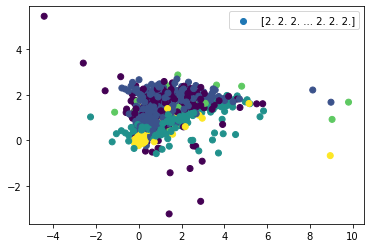

In [186]:
plt.scatter(X_test[:,0], X_test[:,1], c = label_test, label = label_test) # Check other components, against y...
plt.legend()